In [1]:
import pandas as pd
import hddm
import numpy as np
import os

allSubjData = hddm.load_csv('data.csv', index_col=0)

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
allSubjData.head()

,subj_idx,response,rt,gain,loss
1,1,1,1.793,18,-12
2,1,0,1.637,10,-15
3,1,1,1.316,34,-16
4,1,1,1.670,18,-5
5,1,1,1.232,26,-13


In [3]:
data = allSubjData[allSubjData['subj_idx'] != 15]
data.head()

,subj_idx,response,rt,gain,loss
1,1,1,1.793,18,-12
2,1,0,1.637,10,-15
3,1,1,1.316,34,-16
4,1,1,1.670,18,-5
5,1,1,1.232,26,-13


In [4]:
m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss - 1'], include=('z'), group_only_regressors=False)

Adding these covariates:
['v_gain', 'v_loss']


In [5]:
m.find_starting_values()

/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [6]:
if not os.path.exists('savedModels/no_alpha'):
    os.makedirs('savedModels/no_alpha')

m.sample(10000, burn=2500, dbname='savedModels/no_loss_aversion/db_no_alpha', db='pickle')

 [-----------------100%-----------------] 10001 of 10000 complete in 18313.7 sec

In [7]:
m.save('savedModels/no_loss_aversion/no_alpha')

In [125]:
def run_model(id):
    import pandas as pd
    import hddm
    import numpy as np
    import os

    allSubjData = hddm.load_csv('data.csv', index_col=0)    
    data = allSubjData[allSubjData['subj_idx'] != 15]
    
    m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)
    m.find_starting_values()
    m.sample(25000, burn=5000, dbname='savedModels/fullModel/db_fullModel_{}'.format(id), db='pickle')
    m.save('savedModels/fullModel/fullModel_{}'.format(id))
    
    return m

In [126]:
from kabuki.analyze import gelman_rubin

from ipyparallel import Client
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()
statistic = gelman_rubin(models)

In [127]:
import numpy as np
allStatValues = statistic.values()
print(np.max(allStatValues))

1.0043100388161659


In [150]:
m = models[3]

## Model parameters

In [9]:
m.print_stats()

                       mean         std         2.5q          25q          50q         75q        97.5q       mc err
a                   1.88958   0.0766051      1.74822      1.83808      1.88785     1.93597      2.04846   0.00111051
a_std              0.283121   0.0638813     0.185693     0.237905      0.27332    0.317619     0.438028  0.000984291
a_subj.1            1.87849   0.0609694      1.76641      1.83566      1.87702     1.91926      2.00202  0.000981664
a_subj.2             2.1459   0.0628071      2.02699      2.10202       2.1446      2.1873      2.26973  0.000871788
a_subj.3            1.80097   0.0561779      1.69496       1.7627      1.79974     1.83805      1.91646   0.00068476
a_subj.4            1.89718    0.058308      1.79006      1.85658      1.89516     1.93522      2.01755  0.000843756
a_subj.5            2.33776   0.0870214      2.17204      2.27935      2.33511      2.3947      2.51535   0.00128132
a_subj.6            1.35872   0.0392885      1.28421      1.3311

$\lambda$

In [151]:
import numpy as np

In [152]:
modelParamsDF = m.nodes_db
# modelParamsDF.to_csv("fullModel_params.csv")

# group level mean of lambda
groupLevelMeanOfLambda = modelParamsDF.loc['v_loss', 'mean']/modelParamsDF.loc['v_gain', 'mean']
print("group level mean of lamdba is: ", groupLevelMeanOfLambda)

# 95% CI for beta_G, beta_L
print("2.5% percentile for beta_L: ", modelParamsDF.loc['v_loss', '2.5q'])
print("97.5% percentile for beta_G: ", modelParamsDF.loc['v_gain', '97.5q'])

('group level mean of lamdba is: ', -7.899067580853258)
('2.5% percentile for beta_L: ', -0.02010217778937591)
('97.5% percentile for beta_G: ', 0.005873033877337634)


In [153]:
allSubjectsIndex = list(set(data['subj_idx']))
print(allSubjectsIndex)
totalNumSubjects = len(allSubjectsIndex)
print(totalNumSubjects)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]
15


In [154]:
# how many participants have beta_L > beta_G, how many have the 95% CI greater?
# participant level mean (SD) of lambda
numLambdaMean = 0
numLambdaCI = 0
allParticipantLambdas = []

for subjectIndex in allSubjectsIndex:
    beta_gain = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    beta_L_lowerBound = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), '2.5q']
    beta_G_upperBound = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), '97.5q']
    
    if beta_loss > beta_gain:
        numLambdaMean += 1
        
    if beta_L_lowerBound > beta_G_upperBound:
        numLambdaCI += 1
        
    lambdaForThisParticipant = beta_loss/beta_gain
    allParticipantLambdas.append(lambdaForThisParticipant)

print("Number of people with beta_L > beta_G = ", numLambdaMean)
# print("Number of people with 95% CI of beta_L > beta_G = ", numLambdaCI)
print("Average lambda over all individuals = {} ({})".format(np.mean(allParticipantLambdas), np.std(allParticipantLambdas)))

('Number of people with beta_L > beta_G = ', 0)
Average lambda over all individuals = 136.179802852 (564.244373755)


In [157]:
print(allParticipantLambdas)

[-44.49421147635589, -21.718767875999546, -7.856228389802341, -4.982515960001578, -55.792757253474285, -8.48453790175824, -5.096013297163748, -4.357788055221792, -7.7682681581984685, -3.5561686838348363, -5.456565012593484, -24.66247811337988, -3.692146603729867, 2246.602220865484, -5.986731299115682]


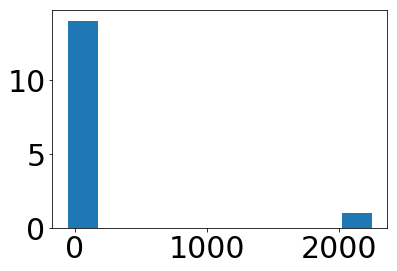

In [156]:
plt.hist(allParticipantLambdas)
plt.show()

In [97]:
print("beta_L mean:", modelParamsDF.loc['v_loss', 'mean'])
print("beta_L 2.5q:", modelParamsDF.loc['v_loss', '2.5q'])
print("beta_L 97.5q:", modelParamsDF.loc['v_loss', '97.5q'])
print("beta_L median", modelParamsDF.loc['v_loss', '50q'])
print("beta_L SD", modelParamsDF.loc['v_loss', 'std'])

print("beta_G mean:", modelParamsDF.loc['v_gain', 'mean'])
print("beta_G 2.5q:", modelParamsDF.loc['v_gain', '2.5q'])
print("beta_G 97.5q:", modelParamsDF.loc['v_gain', '97.5q'])
print("beta_G median", modelParamsDF.loc['v_gain', '50q'])
print("beta_G SD", modelParamsDF.loc['v_gain', 'std'])

('beta_L mean:', -0.01004721860740195)
('beta_L 2.5q:', -0.02013316992270589)
('beta_L 97.5q:', -0.0006124675619055345)
('beta_L median', -0.009941745387727052)
('beta_L SD', 0.004869919844142778)
('beta_G mean:', 0.001076173706467709)
('beta_G 2.5q:', -0.0033744064068597104)
('beta_G 97.5q:', 0.0054514041335700075)
('beta_G median', 0.0010603645278543707)
('beta_G SD', 0.0022051916629765526)


$\gamma$

In [98]:
meanA = modelParamsDF.loc['a', 'mean']
print("mean value of threshold: ", meanA)

# 95 CI interval
Z_CI_lowerBound = (modelParamsDF.loc['z'.format(subjectIndex), '2.5q'] - 0.5)*meanA
Z_CI_upperBound = (modelParamsDF.loc['z'.format(subjectIndex), '97.5q'] - 0.5)*meanA
print("confidence interval of gamma: ", Z_CI_lowerBound, Z_CI_upperBound)

('mean value of threshold: ', 1.8941146627954248)
('confidence interval of gamma: ', -0.028283342026764698, 0.03303457666760628)


In [99]:
# mean gamma across all participants, how many participants have 95% CI of gamma strictly negative
allParticipantsZ = []
countGammaMean = 0
countGammaCI = 0

for participantIndex in allSubjectsIndex:
    a_participant = modelParamsDF.loc['a_subj.{}'.format(participantIndex), 'mean']
    z_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), 'mean'] - 0.5)*meanA
    allParticipantsZ.append(z_participant)
    z_upperBound_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), '97.5q'] - 0.5)*meanA
    
    if z_upperBound_participant < 0:
        countGammaCI += 1
        
    if z_participant < 0:
        countGammaMean += 1
    
mean_Z = np.mean(allParticipantsZ)
SD_Z = np.std(allParticipantsZ)
print("Mean value of pre-valuation bias across all participants: {} ({})".format(mean_Z, SD_Z))
print("Number of participants with negative gamma: ", countGammaMean)
print("Number of participants with 95% CI of gamma negative: ", countGammaCI)

Mean value of pre-valuation bias across all participants: 0.00195705780741 (0.0211589470016)
('Number of participants with negative gamma: ', 7)
('Number of participants with 95% CI of gamma negative: ', 0)


In [100]:
print("gamma mean:", (modelParamsDF.loc['z', 'mean'] - 0.5)*meanA)
print("gamma 2.5q:", (modelParamsDF.loc['z', '2.5q'] - 0.5)*meanA)
print("gamma 97.5q:", (modelParamsDF.loc['z', '97.5q'] - 0.5)*meanA)
print("gamma median", (modelParamsDF.loc['z', '50q'] - 0.5)*meanA)
print("gamma SD", (modelParamsDF.loc['z', 'std'])*meanA)

('gamma mean:', 0.0018764184120393108)
('gamma 2.5q:', -0.028283342026764698)
('gamma 97.5q:', 0.03303457666760628)
('gamma median', 0.0016134404591002266)
('gamma SD', 0.015689254746597093)


$\alpha$

In [101]:
# group-level mean
print("Group-level mean of alpha is: ", modelParamsDF.loc['v_Intercept'.format(subjectIndex), 'mean'])

# how many participants have mean and 95% CI negative?
allParticipantsAlphas = []
countAlphaMean = 0
countAlphaCI = 0

for participantIndex in allSubjectsIndex:
    alpha_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean']
    allParticipantsAlphas.append(alpha_participant)
    alpha_upperBound_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), '97.5q']
    
    if alpha_upperBound_participant < 0:
        countAlphaCI += 1
        
    if alpha_participant < 0:
        countAlphaMean += 1
        
mean_alpha = np.mean(allParticipantsAlphas)
SD_alpha = np.std(allParticipantsAlphas)
print("Mean value of fixed utility bias across all participants: {} ({})".format(mean_alpha, SD_alpha))
print("Number of participants with negative alpha: ", countAlphaMean)
print("Number of participants with 95% CI of alpha negative: ", countAlphaCI)

('Group-level mean of alpha is: ', -0.08253254674419895)
Mean value of fixed utility bias across all participants: -0.0870938923676 (0.534555792664)
('Number of participants with negative alpha: ', 9)
('Number of participants with 95% CI of alpha negative: ', 6)


In [102]:
print("alpha mean:", modelParamsDF.loc['v_Intercept', 'mean'])
print("alpha 2.5q:", modelParamsDF.loc['v_Intercept', '2.5q'])
print("alpha 97.5q:", modelParamsDF.loc['v_Intercept', '97.5q'])
print("alpha median", modelParamsDF.loc['v_Intercept', '50q'])
print("alpha SD", modelParamsDF.loc['v_Intercept', 'std'])

('alpha mean:', -0.08253254674419895)
('alpha 2.5q:', -0.4425260452473132)
('alpha 97.5q:', 0.27206137026772825)
('alpha median', -0.08216422433033622)
('alpha SD', 0.181148768594707)


# Correlation with rejection rates

In [158]:
def getPAcceptFromSubjectIndex(subjectIndex):
    subjectResponses = np.array(data.loc[data['subj_idx'] == subjectIndex]['response'])
    return np.mean(subjectResponses)

allParticipants_p_accept = np.array([getPAcceptFromSubjectIndex(subjectIndex) for subjectIndex in allSubjectsIndex])
allParticipants_p_accept

array([0.85098039, 0.29508197, 0.23622047, 0.24497992, 0.37086093,
       0.5       , 0.75423729, 0.71713147, 0.32142857, 0.77865613,
       0.85826772, 0.60816327, 0.29803922, 0.468     , 0.53125   ])

In [159]:
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

('Pearson correlation between Lambda and P(Acceptance) is: ', (-0.06708395696020988, 0.8122367295646191))


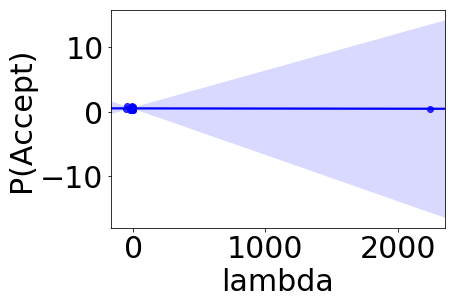

In [160]:
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue')
plt.xlabel("lambda")
plt.ylabel("P(Accept)")
print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))

('Pearson correlation between gamma and P(Acceptance) is: ', (0.5978674919336018, 0.018572749697774886))


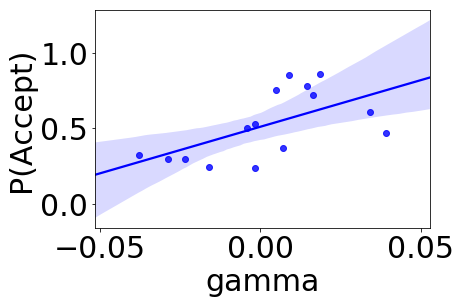

In [161]:
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue')
plt.xlabel("gamma")
plt.ylabel("P(Accept)")
print("Pearson correlation between gamma and P(Acceptance) is: ", pearsonr(allParticipantsZ, allParticipants_p_accept))

('Pearson correlation between alpha and P(Acceptance) is: ', (0.9869751160200148, 1.0612877039064082e-11))


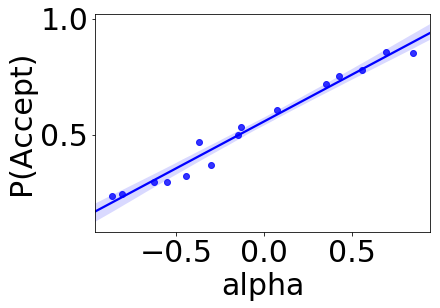

In [162]:
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue')
plt.xlabel("alpha")
plt.ylabel("P(Accept)")
print("Pearson correlation between alpha and P(Acceptance) is: ", pearsonr(allParticipantsAlphas, allParticipants_p_accept))

# Correlation with lambda (traditional method -- computed using logistic regression)

In [163]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

In [164]:
from sklearn.linear_model import LogisticRegression
allSubjectsIndex = np.array(allSubjectsIndex)
indicesToAnalyze = allSubjectsIndex[allParticipants_p_accept[:] != 0]

def computeParticipantLambdaLR(subjectIndex):
    participantData = data[data['subj_idx'] == subjectIndex]
    X = participantData[['gain', 'loss']]
    y = participantData['response']
    classifier = LogisticRegression(C=1e5).fit(X, y)
    coefficients = classifier.coef_
    participantLambdaLR = coefficients[0][1]/coefficients[0][0]
    return participantLambdaLR

allParticipantLambdasLR = [computeParticipantLambdaLR(_) for _ in indicesToAnalyze]

In [165]:
print('lambda LR min: {}, max: {}, median: {}'.format(np.min(allParticipantLambdasLR), np.max(allParticipantLambdasLR), np.median(allParticipantLambdasLR)))
print(len(allParticipantLambdasLR))

lambda LR min: 0.989935285484, max: 7.03334914619, median: 1.93423091329
15


In [166]:
print(allParticipantLambdasLR)

[0.9899352854840588, 3.453305801759754, 7.033349146194107, 2.660130234939878, 2.665169272704418, 1.4177859538286908, 1.3983864066361502, 1.1293814260736712, 2.3637835822539737, 1.084978076798603, 1.1126526770859366, 1.9342309132896187, 1.938842374657405, 2.6021258708831616, 1.683946730216291]


In [167]:
print("Lambda computed using logistic regression, mean: {}, SD: {}".format(np.mean(allParticipantLambdasLR), np.std(allParticipantLambdasLR)))

Lambda computed using logistic regression, mean: 2.23120025019, SD: 1.46582717539


(array([0., 1., 5., 3., 1., 3., 1., 0., 0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 9 Patch objects>)

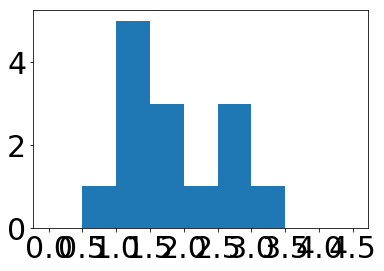

In [168]:
from matplotlib import pyplot as plt
plt.xticks(np.arange(0, 5, 0.5))
plt.hist(allParticipantLambdasLR, np.arange(0, 5, 0.5))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.6914317915463566, 0.004301613643063369))


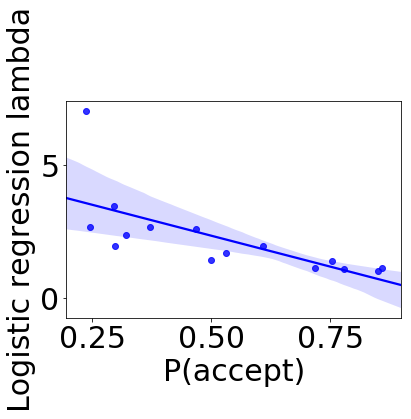

In [169]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# pAcceptToCorrelate = np.array(allParticipants_p_accept)[indicesToAnalyze]
sns.regplot(allParticipants_p_accept, allParticipantLambdasLR, color ='blue')
plt.xlabel("P(accept)")
plt.ylabel("Logistic regression lambda")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(allParticipants_p_accept, allParticipantLambdasLR))

('Pearson correlation between DDM lambda and Logistic regression lambda is: ', (0.06728120328576342, 0.8116937648868648))


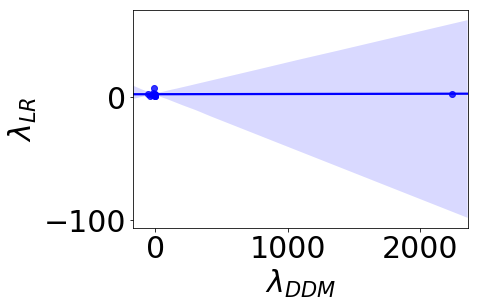

In [170]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
sns.regplot(allParticipantLambdas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\lambda_{DDM}$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between DDM lambda and Logistic regression lambda is: ", pearsonr(allParticipantLambdas, allParticipantLambdasLR))

('Pearson correlation between gamma and Logistic regression lambda is: ', (-0.23011933664031847, 0.4093209190093247))


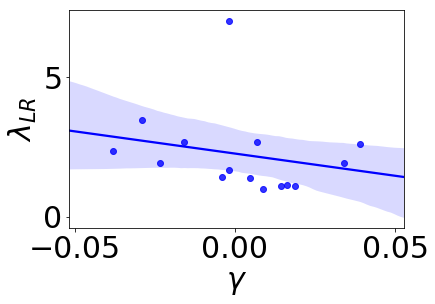

In [171]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
sns.regplot(allParticipantsZ, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between gamma and Logistic regression lambda is: ", pearsonr(allParticipantsZ, allParticipantLambdasLR))

('Pearson correlation between alpha and Logistic regression lambda is: ', (-0.7128522404094629, 0.0028551136173619097))


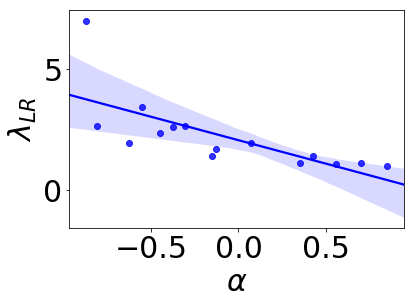

In [172]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
sns.regplot(allParticipantsAlphas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between alpha and Logistic regression lambda is: ", pearsonr(allParticipantsAlphas, allParticipantLambdasLR))